### Pointers in Python: What's the Point?   
https://realpython.com/pointers-in-python/

In [1]:
isinstance(1, object)

True

In [2]:
isinstance(list(), object)

True

In [3]:
isinstance(True, object)

True

In [4]:
def foo():
    pass

In [5]:
isinstance(foo, object)

True

In [6]:
x = 100
y = 49+51
x is y

True

In [7]:
x = 1000
y = 499+501
x is y

False

In [8]:
import ctypes
x = ctypes.c_int()
x

c_long(0)

### Python meta-hacking

In [3]:
import sys
print("Python version =", sys.version)
print("Python version =", sys.version[:6])

Python version = 3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]
Python version = 3.8.11


In [10]:
x = 40
print(x)

40


In [11]:
import ctypes

# PyLongObject structure
class IntStruct (ctypes.Structure):
    # declaration of fields
    _fields_ = [("ob_refcnt", ctypes.c_long),
                ("ob_type", ctypes.c_void_p),
                ("ob_size", ctypes.c_long),
                ("ob_digit", ctypes.c_int)]

    def __repr__ (self):
        return (f"IntStruct (ob_digit = {self.ob_digit}, "
                f"ob_size = {self.ob_size}, "
                f"refcount = {self.ob_refcnt})")

In [12]:
int42 = IntStruct.from_address(id(42))
print(int42)

int_minus_2 = IntStruct.from_address(id(-2))
print(int_minus_2) # ob_digit = 2, ob_size = -1

int42.ob_digit

# change the value in the list of preallocated numbers
# int42.ob_digit = 4
# print(4 == 42) # True
# print(1 + 41) # 4

IntStruct (ob_digit = 0, ob_size = 1, refcount = 32)
IntStruct (ob_digit = -1, ob_size = -1, refcount = 64)


0

In [13]:
x = 40
y = 40
id(x) == id(y)

True

In [14]:
x = 1230
y = 1230
id(x) == id(y)

False

Text(0, 0.5, 'reference count')

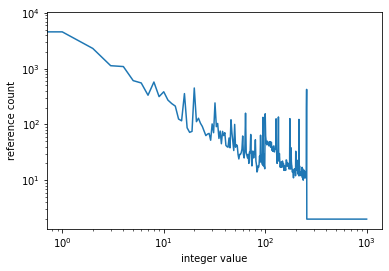

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
plt.loglog(range(1000), [sys.getrefcount(i) for i in range(1000)])
plt.xlabel('integer value')
plt.ylabel('reference count')

In [16]:
## Need checking why it is not True
all(i == IntStruct.from_address(id(i)).ob_digit
    for i in range(256))

False

In [17]:
for i in range(10):
    print(IntStruct.from_address(id(i)).ob_digit)

0
0
0
0
0
0
0
0
0
0


In [18]:
2**100

1267650600228229401496703205376

In [19]:
class ListStruct(ctypes.Structure):
    _fields_ = [("ob_refcnt", ctypes.c_long),
                ("ob_type", ctypes.c_void_p),
                ("ob_size", ctypes.c_ulong),
                ("ob_item", ctypes.c_long),  # PyObject** pointer cast to long
                ("allocated", ctypes.c_ulong)]
    
    def __repr__(self):
        return ("ListStruct(len={self.ob_size}, "
                "refcount={self.ob_refcnt})").format(self=self)

In [20]:
L = [1,2,3,4,5]
ListStruct.from_address(id(L))

ListStruct(len=5, refcount=1)

In [21]:
tup = [L, L]  # two more references to L
ListStruct.from_address(id(L))

ListStruct(len=5, refcount=3)

In [22]:
tup2 = [L, L, L, L]
ListStruct.from_address(id(L))

ListStruct(len=5, refcount=7)

In [23]:
# get a raw pointer to our list
Lstruct = ListStruct.from_address(id(L))

# create a type which is an array of integer pointers the same length as L
PtrArray = Lstruct.ob_size * ctypes.POINTER(IntStruct)

# instantiate this type using the ob_item pointer
L_values = PtrArray.from_address(Lstruct.ob_item)

In [24]:
Lstruct.ob_item

0

In [25]:
#[ptr[0] for ptr in L_values]  # ptr[0] dereferences the pointer

In [26]:
import numpy as np
np.__version__

'1.20.3'

In [27]:
class NumpyStruct(ctypes.Structure):
    _fields_ = [("ob_refcnt", ctypes.c_long),
                ("ob_type", ctypes.c_void_p),
                ("ob_data", ctypes.c_long),  # char* pointer cast to long
                ("ob_ndim", ctypes.c_int),
                ("ob_shape", ctypes.c_voidp),
                ("ob_strides", ctypes.c_voidp)]
    
    @property
    def shape(self):
        return tuple((self.ob_ndim * ctypes.c_int64).from_address(self.ob_shape))
    
    @property
    def strides(self):
        return tuple((self.ob_ndim * ctypes.c_int64).from_address(self.ob_strides))
    
    def __repr__(self):
        return ("NumpyStruct(shape={self.shape}, "
                "refcount={self.ob_refcnt})").format(self=self)

In [ ]:
x = np.random.random((10, 20))
xstruct = NumpyStruct.from_address(id(x))
xstruct